##  Importowanie bibliotek i wczytanie ścieżek

In [1]:
# Importowanie bibliotek
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import cv2
import random
import time



# Ścieżki do folderów z danymi
train_path2 = "./images/train-kopia/" # 3 klasy
train_path = "./images/train/" # 6 klas

val_path = "./images/validation/"

# Rozmiar obrazów
pic_size = 48

# Lista emocji (kategorii)
# Lista emocji (kategorii) - pominięcie pliku .DS_Store i kategorii 'discust' bo ma za malo danych dla poprawy modelu
emotions = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder)) and folder != 'disgust']
print("Emotions:", emotions)


Emotions: ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry']


## Ilość obrazów w kadej kategorii w folderze treningowym

In [23]:
def count_images_per_category(train_path, emotions):
    image_counts = {}
    
    for emotion in emotions:
        emotion_path = os.path.join(train_path, emotion)
        # Lista wszystkich plików w folderze
        images = [f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
        image_counts[emotion] = len(images)  # Liczba obrazków w kategorii
    
    return image_counts

# Liczenie obrazków w każdej kategorii
image_counts = count_images_per_category(train_path, emotions)

# Wyświetlanie wyników
for emotion, count in image_counts.items():
    print(f"Kategoria: {emotion}, Liczba obrazków: {count}")

Kategoria: happy, Liczba obrazków: 7164
Kategoria: sad, Liczba obrazków: 4938
Kategoria: fear, Liczba obrazków: 4103
Kategoria: surprise, Liczba obrazków: 3205
Kategoria: neutral, Liczba obrazków: 4982
Kategoria: angry, Liczba obrazków: 3993


## Funkcja do wyświetlania 3 losowych obrazów z każdej kategorii, zapoznanie z danymi

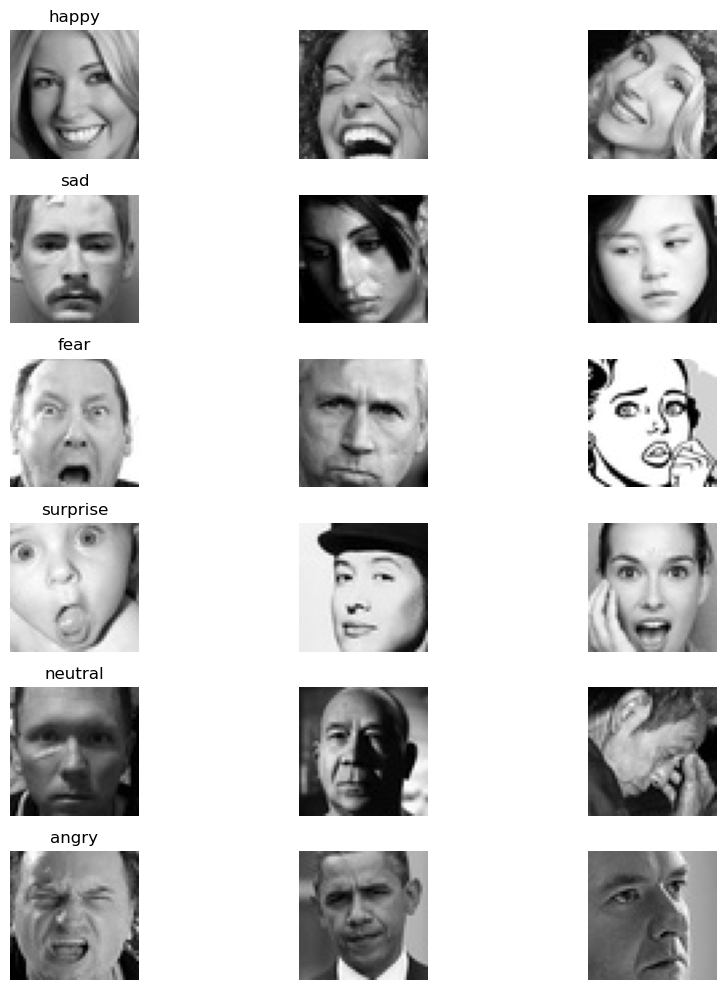

In [24]:
def display_random_images(train_path, emotions, pic_size):
    fig, axes = plt.subplots(len(emotions), 3, figsize=(10, 10))
    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(train_path, emotion)
        images = [f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
        
        # Wybieranie 3 losowych obrazów z każdej kategorii
        random_images = random.sample(images, 3)
        
        for j, image_name in enumerate(random_images):
            img_path = os.path.join(emotion_path, image_name)
            img = load_img(img_path, target_size=(pic_size, pic_size), color_mode="grayscale")
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(emotion)  # Tytuł kategorii
    
    plt.tight_layout()
    plt.show()

# Wyświetlanie losowych próbek
display_random_images(train_path, emotions, pic_size)


## Przygotowanie danych treningowych i walidacyjnych

In [2]:
train_data = []
train_labels = []

for emotion in emotions:
    emotion_path = os.path.join(train_path, emotion)
    if not os.path.isdir(emotion_path):
        continue

    for img_name in os.listdir(emotion_path):
        if img_name == '.DS_Store':
            continue

        img_path = os.path.join(emotion_path, img_name)
        img = load_img(img_path, target_size=(pic_size, pic_size), color_mode='grayscale')
        img_array = img_to_array(img)
        train_data.append(img_array)
        train_labels.append(emotions.index(emotion))  # Przypisanie etykiety numerycznej

# Przygotowanie danych walidacyjnych
val_data = []
val_labels = []

for emotion in emotions:
    emotion_path = os.path.join(val_path, emotion)
    if not os.path.isdir(emotion_path):
        continue

    for img_name in os.listdir(emotion_path):
        if img_name == '.DS_Store':
            continue

        img_path = os.path.join(emotion_path, img_name)
        img = load_img(img_path, target_size=(pic_size, pic_size), color_mode='grayscale')
        img_array = img_to_array(img)
        val_data.append(img_array)
        val_labels.append(emotions.index(emotion))  # Przypisanie etykiety numerycznej

# Normalizacja danych
train_data = np.array(train_data, dtype="float32") / 255.0
train_labels = np.array(train_labels)
val_data = np.array(val_data, dtype="float32") / 255.0
val_labels = np.array(val_labels)

# One-hot encoding etykiet
train_labels = to_categorical(train_labels, len(emotions))
val_labels = to_categorical(val_labels, len(emotions))

## Tworzenie modelu i trenowanie

In [26]:
# Tworzenie modelu
model = Sequential()

# Warstwy konwolucyjne z BatchNormalization i Dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(pic_size, pic_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Spłaszczenie
model.add(Flatten())

# Warstwy gęste z Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Zwiększenie Dropoutu w pełnych warstwach
model.add(Dense(len(emotions), activation='softmax'))  # Wyjście: liczba emocji

# Kompilowanie modelu z innymi parametrami
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_data, train_labels, epochs=40, batch_size=32, validation_data=(val_data, val_labels))

# Ocena modelu
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Zapisanie modelu
model.save("emotion_recognition_model.keras")

Epoch 1/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 53ms/step - accuracy: 0.2136 - loss: 2.0688 - val_accuracy: 0.2779 - val_loss: 1.7295
Epoch 2/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.2526 - loss: 1.7429 - val_accuracy: 0.2998 - val_loss: 1.6357
Epoch 3/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.2964 - loss: 1.6787 - val_accuracy: 0.4075 - val_loss: 1.4900
Epoch 4/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.3541 - loss: 1.5754 - val_accuracy: 0.4365 - val_loss: 1.4058
Epoch 5/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.3833 - loss: 1.5242 - val_accuracy: 0.4420 - val_loss: 1.3795
Epoch 6/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.4049 - loss: 1.4859 - val_accuracy: 0.4759 - val_loss: 1.3441
Epoch 7/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.4288 - loss: 1.4287 - val_accuracy: 0.5034 - val_loss: 1.2872
Epoch 8/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.4380 - loss: 1.4011 - 

## Funkcja do obliczania macierzy pomyłek

218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


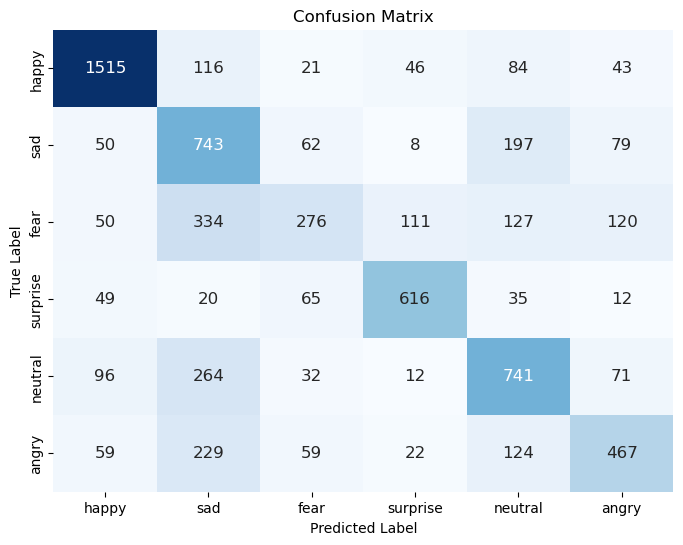

In [5]:
# Wczytanie zapisanego modelu
model = load_model("emotion_recognition_model.keras")

def plot_confusion_matrix(model, val_data, val_labels, emotions):
    # Uzyskiwanie przewidywań
    val_predictions = model.predict(val_data)
    val_predictions = np.argmax(val_predictions, axis=1)  # Przewidywania w postaci indeksów

    # Uzyskiwanie prawdziwych etykiet
    val_labels = np.argmax(val_labels, axis=1)  # Konwersja one-hot encoding na indeksy

    # Obliczanie macierzy pomyłek
    cm = confusion_matrix(val_labels, val_predictions)

    # Tworzenie DataFrame dla lepszej wizualizacji
    cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)

    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Wywołanie funkcji w celu wyświetlenia macierzy pomyłek
plot_confusion_matrix(model, val_data, val_labels, emotions)


## Wczytanie modelu i funkcja predict_emotion

In [6]:
def predict_emotion(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Przekształcanie obrazu na skalę szarości
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # Ładowanie klasyfikatora twarzy
    
    # Zwiększenie wartości scaleFactor i minNeighbors, aby zmniejszyć fałszywe wykrycia
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=4, minSize=(30, 30))  # Wykrywanie twarzy
    
    if len(faces) == 0:  # Jeśli nie wykryto twarzy, zwróć oryginalny obraz
        return frame

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]  # Wycinanie twarzy
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)  # Konwertowanie twarzy na skalę szarości
        
        # Równoważenie histogramu (poprawa oświetlenia)
        face_gray = cv2.equalizeHist(face_gray)
        
        # Zmiana rozmiaru twarzy
        face_resized = cv2.resize(face_gray, (pic_size, pic_size))  # Zmiana rozmiaru twarzy
        face_resized = face_resized.reshape(1, pic_size, pic_size, 1)  # Reshape twarzy do formatu (1, 48, 48, 1)
        face_resized = face_resized / 255.0  # Normalizacja obrazu
        
        # Przewidywanie emocji
        prediction = model.predict(face_resized)
        max_index = np.argmax(prediction[0])
        emotion_predicted = emotions[max_index]
        
        # Wyświetlanie wyniku
        cv2.putText(frame, emotion_predicted, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return frame

## Uruchamianie kamery

In [8]:
import cv2
import time

# Uruchomienie kamery
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Nie udało się otworzyć kamery.")
    exit()

# Rozpoczęcie liczenia czasu
start_time = time.time()

while True:
    ret, frame = cap.read()  # Odczytanie obrazu z kamery
    if not ret:
        print("Nie udało się odczytać obrazu z kamery.")
        break
    
    # Dodaj sprawdzanie rozmiaru klatki
    height, width = frame.shape[:2]  # Pobranie tylko wymiarów obrazu (bez kanałów)
    if height == 0 or width == 0:
        print("Klatka nie zawiera obrazu.")
        break

    # Przewidywanie emocji na obrazie
    try:
        frame = predict_emotion(frame)  # Upewnij się, że predict_emotion() jest poprawnie zaimplementowane
    except Exception as e:
        print(f"Błąd podczas przewidywania emocji: {e}")
        break
    
    # Wyświetlanie obrazu z wykrytymi emocjami
    cv2.imshow('Emotion Recognition', frame)
    
    # Sprawdzanie, czy upłynęło 60 sekund
    elapsed_time = time.time() - start_time
    if elapsed_time > 60:
        print("Czas działania minął 60 sekund.")
        break  # Przerwij po 60 sekundach

    # Zatrzymanie kamery po naciśnięciu 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Przerwano ręcznie.")
        break

# Zwolnienie zasobów
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

## Podsumowanie

### Podsumowanie i wnioski
Podsumowując cały projekt, był to bardzo ciekawy i wartościowy proces. Na początku podzieliłem dane na dwie opcje: trzy klasy i sześć klas. Podczas obróbki danych zauważyłem, że dane z kategorii "disgust" były zbyt ograniczone, przez co zdecydowałem się je usunąć z analizy, aby nie zaburzały modelu. Następnie, aby lepiej zrozumieć dane, wyświetliłem po trzy losowe obrazy z każdej kategorii, co pomogło mi w lepszym przygotowaniu zbioru danych.

Podczas pracy na Macu napotkałem problem z tworzeniem dodatkowego folderu DS Store, który zawierał informacje o lokalizacji plików i błędnie interpretował te pliki jako nazwy emocji. Udało się to naprawić, uwzględniając ten problem w dalszym przetwarzaniu danych.

Podczas budowy modelu postawiłem na zastosowanie kilku warstw konwolucyjnych, co przyczyniło się do znaczącej poprawy wyników. Po przeprowadzeniu testów zdecydowałem, że 40 epok to optymalna liczba, a zapisanie modelu okazało się bardzo pomocne, ponieważ znacznie przyspieszyło testowanie, eliminując konieczność ponownego generowania modelu za każdym razem.

W analizie wyników widzimy, że najlepiej rozpoznawana jest kategoria "Happy", natomiast "Fear" wypada najgorzej, głównie ze względu na podobieństwa z innymi emocjami. Z moich testów wynika, że model sprawdza się doskonale podczas rozpoznawania emocji na kamerce internetowej, co zostało potwierdzone przez dane.

Jestem bardzo zadowolony z wyników projektu i cieszę się, że mogłem zdobyć nowe doświadczenie, które przyczyniło się do mojej nauki i rozwoju.